## BIBLIOTHEQUES
- `os` pour interagir avec le système de fichiers (lister les images).
- `requests` pour effectuer des requêtes HTTP vers l'API.
- `PIL (Pillow)` pour manipuler les images.
- `matplotlib.pyplot` pour afficher les images et les masques.
- `numpy` pour la manipulation des tableaux (les images sont des tableaux de pixels).
- `tqdm.notebook` pour afficher une barre de progression (utile pour plusieurs images).
- `base64` et `io` pour décoder les masques renvoyés par l'API.

In [37]:
import sns
from dotenv import load_dotenv
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import base64
import io
import time
import cv2
import shutil
import glob
import pandas as pd
import seaborn as sns

## VARIABLES
`CLASS_MAPPING`: Un dictionnaire qui associe les noms de classes (ex: "Hat") à des identifiants numériques.


In [ ]:
load_dotenv()
api_token = os.getenv('FASHION_TREND_INTELLIGENCE_TOKEN_READ')
image_dir = "IMG/"
list_of_image_paths = sorted(os.listdir(image_dir))
print(list_of_image_paths)
model_name = "sayeed99/segformer_b3_clothes"
imgnocompliant = "IMGNoCompliant/"
masknocompliant = "MaskNoCompliant/"

CLASS_MAPPING = {
    "Background": 0,
    "Hat": 1,
    "Hair": 2,
    "Sunglasses": 3,
    "Upper-clothes": 4,
    "Skirt": 5,
    "Pants": 6,
    "Dress": 7,
    "Belt": 8,
    "Left-shoe": 9,
    "Right-shoe": 10,
    "Face": 11,
    "Left-leg": 12,
    "Right-leg": 13,
    "Left-arm": 14,
    "Right-arm": 15,
    "Bag": 16,
    "Scarf": 17
}

## FONCTIONS
1. `get_image_dimensions`: Récupérer les dimensions d'une image.
2. `encode_image_to_base64`: Encoder une image en base64.
3. `decode_base64_mask`: Décoder un masque de base64 en une image (tableau NumPy) et le redimensionner.
4. `detect_content_type` : Recuperer le type de fichiers d'une image (png, jpeg, etc...)
4.  `create_masks`: Combiner les masques de toutes les classes détectées en un seul masque de segmentation final, où chaque pixel a la valeur de l'ID de sa classe.

In [19]:
def get_image_dimensions(img_path):
    """
    Get the dimensions of an image.
    Args:
        img_path (str): Path to the image.
    Returns:
        tuple: (width, height) of the image.
    """
    original_image = Image.open(img_path)
    return original_image.size

def encode_image_to_base64(image_path):
    """
    Encode image to base64.
    Args:
        image_path (str): image.
    Returns:
        encoded_string: Base 67 encoded string.
    """
    # Open the image file in binary read mode
    with open(image_path, "rb") as image_file:
        # Read the file content, encode it to base64, and convert to UTF-8 string
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        # Return the base64 string with proper data URI format for JPEG images
    return f"data:image/png;base64,{encoded_string}"

def decode_base64_mask(base64_string, width, height):
    """
    Decode a base64-encoded mask into a NumPy array.
    Args:
        base64_string (str): Base64-encoded mask.
        width (int): Target width.
        height (int): Target height.
    Returns:
        np.ndarray: Single-channel mask array.
    """
    mask_data = base64.b64decode(base64_string)
    mask_image = Image.open(io.BytesIO(mask_data))
    mask_array = np.array(mask_image)
    if len(mask_array.shape) == 3:
        mask_array = mask_array[:, :, 0]  # Take first channel if RGB
    mask_image = Image.fromarray(mask_array).resize((width, height), Image.NEAREST)
    return np.array(mask_image)

def detect_content_type(image_path_full):
    """
    Detect Content type of image.
    Args:
        image_path_full (str): image path.
    Returns:
        format_to_mime: image format.
    """
    try:
        with Image.open(image_path_full) as img:
            format_to_mime = {
                'JPEG': 'image/jpeg',
                'PNG': 'image/png',
                'GIF': 'image/gif',
                'BMP': 'image/bmp',
                'WEBP': 'image/webp',
                'TIFF': 'image/tiff',
                'ICO': 'image/x-icon',
            }
            return format_to_mime.get(img.format, f'image/{img.format.lower()}')
    except Exception as e:
        print(f"Error {e}")
        return None

def create_masks(results, width, height):
    """
    Combine multiple class masks into a single segmentation mask.
    Args:
        results (list): List of dictionaries with 'label' and 'mask' keys.
        width (int): Target width.
        height (int): Target height.
    Returns:
        np.ndarray: Combined segmentation mask with class indices.
    """
    combined_mask = np.zeros((height, width), dtype=np.uint8)  # Initialize with Background (0)

    # Process non-Background masks first
    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)
        if class_id == 0:  # Skip Background
            continue
        mask_array = decode_base64_mask(result['mask'], width, height)
        combined_mask[mask_array > 0] = class_id

    # Process Background last to ensure it doesn't overwrite other classes unnecessarily
    # (Though the model usually provides non-overlapping masks for distinct classes other than background)
    for result in results:
        if result['label'] == 'Background':
            mask_array = decode_base64_mask(result['mask'], width, height)
            # Apply background only where no other class has been assigned yet
            # This logic might need adjustment based on how the model defines 'Background'
            # For this model, it seems safer to just let non-background overwrite it first.
            # A simple application like this should be fine: if Background mask says pixel is BG, set it to 0.
            # However, a more robust way might be to only set to background if combined_mask is still 0 (initial value)
            combined_mask[mask_array > 0] = 0 # Class ID for Background is 0

    return combined_mask

## SEGMENTATION

In [ ]:
def segment_images_batch(list_of_image_paths):
    """
    Segmente une liste d'images en utilisant l'API Hugging Face.
    Args:
        list_of_image_paths (list): Liste des chemins vers les images.
    Returns:
        list: Liste des masques de segmentation (tableaux NumPy).
              Contient None si une image n'a pas pu être traitée.
    """
    batch_segmentations = []
    start_time = time.time()

    for image_path in tqdm(list_of_image_paths,desc="Segmentation",unit="image",colour="green"):
        try:
            image_path_full = image_dir + image_path

            # Image Dimensions
            image_dimensions = get_image_dimensions(image_path_full)
            # Content Type
            content_type = detect_content_type(image_path_full)

            if content_type == "image/png" and image_dimensions == (400, 600):

                print(f"Traitement: {image_path}")

                ############### API Request ################
                api_url = f"https://api-inference.huggingface.co/models/{model_name}"
                headers = {
                    "Authorization": f"Bearer {api_token}",
                    "Content-Type": "application/json"
                }
                base64_image = encode_image_to_base64(image_path_full)
                payload = {"inputs": base64_image}

                try:
                    response = requests.post(api_url, headers=headers, json=payload, timeout=30)
                    response.raise_for_status()
                    print(f" HTTP Status Code: {response.status_code}")

                    # Store response data
                    response_data = response.json()

                    # Create Mask
                    combined_mask = create_masks(response_data, image_dimensions[0], image_dimensions[1])
                    # Append List
                    batch_segmentations.append(combined_mask)

                except requests.exceptions.HTTPError as http_err:
                    print(f"HTTP error occurred for {image_path}: {http_err}")
                    batch_segmentations.append(None)

                except requests.exceptions.Timeout:
                    print(f"Timeout error for {image_path}")
                    batch_segmentations.append(None)

                except requests.exceptions.RequestException as req_err:
                    print(f"Request error for {image_path}: {req_err}")
                    batch_segmentations.append(None)

                except Exception as e:
                    print(f"Error during API request {image_path}: {e}")
                    batch_segmentations.append(None)

            else:
                print(f"Image {image_path} ne correspond pas aux critères (PNG 400x600)")
                try:

                    imgnocompliant_destination = os.path.join(imgnocompliant, os.path.basename(image_path))
                    shutil.move(image_path_full, imgnocompliant_destination)

                    # Mask/mask_0.png  MaskNoCompliant/mask_0.png
                    numero = (image_path.split("_")[1]).split(".")[0]
                    masknocompliant_source = "Mask/mask_" + numero +".png"
                    masknocompliant_destination = "MaskNoCompliant/mask_" + numero +".png"
                    shutil.move(masknocompliant_source, masknocompliant_destination)
                    print(f"  -> Image déplacée vers: {imgnocompliant_destination} et {masknocompliant_destination}")
                except Exception as move_err:
                    print(f"  -> Erreur lors du déplacement de {image_path}: {move_err}")

                batch_segmentations.append(None)

        except Exception as e:
            print(f"Erreur lors du traitement de {image_path}: {e}")
            batch_segmentations.append(None)

    print("--- %s seconds ---" % (time.time() - start_time))
    return batch_segmentations

# Appeler la fonction pour segmenter les images listées dans image_paths
if list_of_image_paths:
    print(f"\nTraitement de {len(list_of_image_paths)} image(s) en batch...")
    batch_seg_results = segment_images_batch(list_of_image_paths)
    print("Traitement en batch terminé.")
    print(f"Résultats: {len([x for x in batch_seg_results if x is not None])} images traitées avec succès")
else:
    batch_seg_results = []
    print("Aucune image à traiter en batch.")

## RESULTATS

In [ ]:
print(f"Nombre total de résultats: {len(batch_seg_results)}")
list_of_image_paths = sorted(os.listdir(image_dir))

def display_segmented_images_batch(list_of_image_paths, segmentation_masks):
    """
    Affiche les images originales et leurs masques segmentés.
    Args:
        original_image_paths (list): Liste des chemins des images originales.
        segmentation_masks (list): Liste des masques segmentés (NumPy arrays).
    """

    for image_path, segmentation_mask in zip(list_of_image_paths, segmentation_masks):
        print(image_path)
        #print(segmentation_mask)
        image_open = Image.open(image_dir + image_path)

        # Premier sous-graphique
        plt.subplot(1, 2, 1)
        plt.imshow(image_open)
        plt.title('Image Original')
        plt.axis('off')

        if  segmentation_mask is not None :
            # Deuxième sous-graphique
            plt.subplot(1, 2, 2)
            plt.imshow(segmentation_mask, cmap='tab10', interpolation='nearest')
            plt.title('Masque Predit')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            numero = (image_path.split("_")[1]).split(".")[0]
            # Sauvegarde du masque dans les dossiers appropriés
            cv2.imwrite(os.path.join("MaskPrediction", f"mask_{numero}.png"), segmentation_mask)

# Afficher les résultats du batch
if batch_seg_results:
    display_segmented_images_batch(list_of_image_paths, batch_seg_results)
else:
    print("Aucun résultat de segmentation à afficher.")

## RESULTATS


In [ ]:
folder_img = "IMG/"
folder_mask_true = "Mask/"
folder_mask_pred = "MaskPrediction/"
folder_concatenated = "IMGConcat/"

# 2. Définition d'un colormap personnalisé et lecture des paires
# Colormap personnalisé pour 4 classes (valeurs 1 à 4) en BGR
custom_colormap = {
    1: (0, 255, 255),  # Jaune - Hat
    2: (0, 165, 255),  # Orange - Hair
    3: (255, 0, 255),  # Magenta - Sunglasses
    4: (0, 0, 255),  # Rouge - Upper-clothes
    5: (255, 255, 0),  # Cyan - Skirt
    6: (0, 255, 0),  # Vert - Pants
    7: (255, 0, 0),  # Bleu - Dress
    8: (128, 0, 128),  # Violet - Belt
    9: (0, 255, 255),  # Jaune - Left-shoe
    10: (255, 140, 0),  # Orange foncé - Right-shoe
    11: (200, 180, 140),  # Beige - Face
    12: (200, 180, 140),  # Beige - Left-leg
    13: (200, 180, 140),  # Beige - Right-leg
    14: (200, 180, 140),  # Beige - Left-arm
    15: (200, 180, 140),  # Beige - Right-arm
    16: (0, 128, 255),  # Bleu clair - Bag
    17: (255, 20, 147)  # Rose - Scarf
}

# Légendes associées aux labels
legend_labels = {
    "0": "Background",
    "1": "Hat",
    "2": "Hair",
    "3": "Sunglasses",
    "4": "Upper-clothes",
    "5": "Skirt",
    "6": "Pants",
    "7": "Dress",
    "8": "Belt",
    "9": "Left-shoe",
    "10": "Right-shoe",
    "11": "Face",
    "12": "Left-leg",
    "13": "Right-leg",
    "14": "Left-arm",
    "15": "Right-arm",
    "16": "Bag",
    "17": "Scarf"
}

# Lecture des paires image/mask depuis les dossiers
list_img = sorted(os.listdir(folder_img))
list_mask_true = sorted(os.listdir(folder_mask_true))
list_mask_pred = sorted(os.listdir(folder_mask_pred))

datas = []
for img, mask_true, mask_pred in zip(list_img, list_mask_true, list_mask_pred):
    img = os.path.join(folder_img, img)
    mask_true = os.path.join(folder_mask_true, mask_true)
    mask_pred = os.path.join(folder_mask_pred, mask_pred)

    idx = (img.split("_")[1]).split(".")[0]

    img = cv2.imread(img, cv2.IMREAD_COLOR)
    mask_true = cv2.imread(mask_true, cv2.IMREAD_GRAYSCALE)
    mask_pred = cv2.imread(mask_pred, cv2.IMREAD_GRAYSCALE)

    new_data = {
        'img': img,
        'mask_true': mask_true,
        'mask_pred': mask_pred,
        'idx': idx,
    }
    datas.append(new_data)

print("Lecture des paires image/mask effectuée.")
print(datas[2])

# 3. Fonctions pour coloriser le masque et ajouter la légende
def colorize_mask(mask, colormap):
    """
    Applique le colormap personnalisé au masque.
    Pour chaque pixel, s'il correspond à un label défini dans colormap,
    la couleur correspondante est assignée.
    """
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in colormap.items():
        colored_mask[mask == label] = color
    return colored_mask


def add_legend(image, legend, start_x=10, start_y=10, box_size=15, spacing=5):
    """
    Ajoute une légende sur l'image.
    Pour chaque label, dessine un rectangle de la couleur correspondante et le texte associé.
    """
    img_with_legend = image.copy()
    y = start_y
    for label, text in legend.items():
        # Récupération de la couleur du label
        color = custom_colormap.get(int(label), (255, 255, 255))
        # Dessin d'un petit rectangle rempli
        cv2.rectangle(img_with_legend, (start_x, y), (start_x + box_size, y + box_size), color, -1)
        # Ajout du texte à droite du rectangle
        cv2.putText(img_with_legend, text, (start_x + box_size + spacing, y + box_size - 2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        y += box_size + spacing
    return img_with_legend


print(f"Nombre d'images à traiter: {len(datas)}")
print(f"Exemple de données chargées:")
print(f"  Index: {datas[0]['idx']}")
print(f"  Image shape: {datas[0]['img'].shape}")
print(f"  Mask true shape: {datas[0]['mask_true'].shape}")
print(f"  Mask pred shape: {datas[0]['mask_pred'].shape}")

# 4. Application du colormap, ajout de la légende et superposition image/mask
for data in datas:
    img = data['img']
    mask_true = data['mask_true']
    mask_pred = data['mask_pred']
    idx = data['idx']

    # Colorisation du masque avec le colormap personnalisé
    colored_mask_true = colorize_mask(mask_true, custom_colormap)
    colored_mask_pred = colorize_mask(mask_pred, custom_colormap)

    # Ajout de la légende sur le masque colorisé
    colored_mask_pred_with_legend = add_legend(colored_mask_pred, legend_labels)

    # Superposition du masque coloré sur l'image originale
    overlay = cv2.addWeighted(img, 0.7, colored_mask_pred, 0.3, 0)
    overlay_with_legend = add_legend(overlay, legend_labels)

    # Concatenation des images sur une seule ligne
    concatenated = np.hstack([img, colored_mask_true, colored_mask_pred_with_legend, overlay])

    # Affichage des résultats dans Colab
    print(f"Résultat {idx} :")

    cv2.imwrite(f"{folder_concatenated}/concat_{idx}.png", concatenated)

    plt.figure(figsize=(15, 5))
    plt.imshow(cv2.cvtColor(concatenated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Paire {idx}")
    plt.show()


## PERFORMANCES


📊 Résultats globaux :
Accuracy moyenne: 98.87%
IoU moyenne: 94.83%
Dice moyenne: 97.33%

🏆 TOP 3 - MEILLEURES PERFORMANCES (Dice Score)
Mask/mask_45.png     | Dice: 0.9879 | IoU: 0.9761 | Acc: 0.9913
Mask/mask_44.png     | Dice: 0.9860 | IoU: 0.9724 | Acc: 0.9942
Mask/mask_47.png     | Dice: 0.9858 | IoU: 0.9719 | Acc: 0.9930

⚠️  TOP 3 - PERFORMANCES À AMÉLIORER (Dice Score)
Mask/mask_23.png     | Dice: 0.9214 | IoU: 0.8543 | Acc: 0.9790
Mask/mask_46.png     | Dice: 0.9489 | IoU: 0.9027 | Acc: 0.9777
Mask/mask_2.png      | Dice: 0.9518 | IoU: 0.9080 | Acc: 0.9791


TypeError: 'Axes' object is not subscriptable

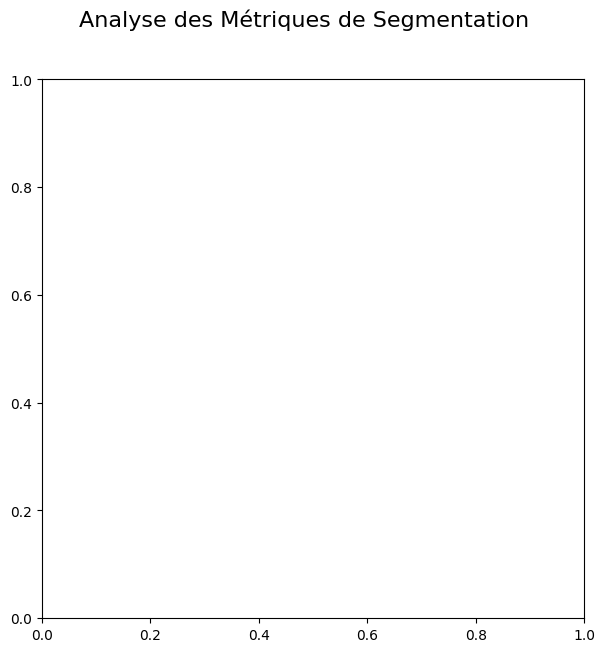

In [46]:
folder_mask_true = "Mask/"
folder_mask_pred = "MaskPrediction/"

# ------------------------
# 1. Fonctions métriques
# ------------------------
def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.size

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 1.0

def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return (2. * intersection) / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) != 0 else 1.0

# ------------------------
# 1. Fonctions métriques
# ------------------------

list_pred_img = sorted(glob.glob(folder_mask_pred + '*.png'))
list_true_img = sorted(glob.glob(folder_mask_true + '*.png'))

results = []

for pred_img, true_img in zip(list_pred_img, list_true_img):

    true_img_open = Image.open(os.path.join(true_img))
    pred_img_open = Image.open(os.path.join(pred_img))

    true_img_convert = np.array(true_img_open)  # niveaux de gris .convert("L")
    true_img_convert = (true_img_convert > 0).astype(np.uint8)  # binarisation 0/1

    pred_img_convert = np.array(pred_img_open)  # niveaux de gris .convert("L")
    pred_img_convert = (pred_img_convert > 0).astype(np.uint8)  # binarisation 0/1

    # Calcul métriques
    acc = pixel_accuracy(true_img_convert, pred_img_convert)
    iou = iou_score(true_img_convert, pred_img_convert)
    dice = dice_score(true_img_convert, pred_img_convert)

    results.append((true_img, acc, iou, dice))
    #print(f"Accuracy: {acc:.4f}, IoU: {iou:.4f}, Dice: {dice:.4f}")

# ------------------------
# 4. Moyennes globales
# ------------------------

df = pd.DataFrame(results, columns=["filename", "accuracy", "iou", "dice"])
#print(df)

if results:
    acc_mean = np.mean([r[1] for r in results])
    iou_mean = np.mean([r[2] for r in results])
    dice_mean = np.mean([r[3] for r in results])

    print("\n📊 Résultats globaux :")
    print(f"Accuracy moyenne: {acc_mean * 100:.2f}%")
    # Cela veut dire que 77% des pixels de tes images sont correctement classés.
    print(f"IoU moyenne: {iou_mean * 100:.2f}%")
    # en moyenne, la zone prédite et la vérité terrain se chevauchent à 61%
    print(f"Dice moyenne: {dice_mean * 100:.2f}%")
    # le chevauchement pondéré est de 74%
else:
    print("⚠️ Aucun résultat calculé.")

# Identification des meilleures et pires performances
print("\n" + "="*60)
print("🏆 TOP 3 - MEILLEURES PERFORMANCES (Dice Score)")
print("="*60)
top_dice = df.nlargest(3, 'dice')[['filename', 'dice', 'iou', 'accuracy']]
for idx, row in top_dice.iterrows():
    print(f"{row['filename']:20} | Dice: {row['dice']:.4f} | IoU: {row['iou']:.4f} | Acc: {row['accuracy']:.4f}")

print("\n" + "="*60)
print("⚠️  TOP 3 - PERFORMANCES À AMÉLIORER (Dice Score)")
print("="*60)
worst_dice = df.nsmallest(3, 'dice')[['filename', 'dice', 'iou', 'accuracy']]
for idx, row in worst_dice.iterrows():
    print(f"{row['filename']:20} | Dice: {row['dice']:.4f} | IoU: {row['iou']:.4f} | Acc: {row['accuracy']:.4f}")

